# DataLoading_Module_Use

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
sys.path.append("../library")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import qat.lang.AQASM as qlm

In [5]:
%load_ext qat.core.magic
%matplotlib inline

The qat.core.magic extension is already loaded. To reload it, use:
  %reload_ext qat.core.magic


In [6]:
global_qlmaas = True
try:
    from qlmaas.qpus import LinAlg
except (ImportError, OSError) as e:
    global_qlmaas = False
from qat.qpus import PyLinalg

In [7]:
def get_qpu(qlmass=False):
    """
    Function for selecting solver. User can chose between:
    * LinAlg: for submitting jobs to a QLM server
    * PyLinalg: for simulating jobs using myqlm lineal algebra.

    Parameters
    ----------

    qlmass : bool
        If True  try to use QLM as a Service connection to CESGA QLM
        If False PyLinalg simulator will be used

    Returns
    ----------
    
    lineal_qpu : solver for quantum jobs
    """
    if qlmass:
        if global_qlmaas:
            print('Using: LinAlg')
            linalg_qpu = LinAlg()
        else:
            raise ImportError("""Problem Using QLMaaS.Please create config file or use mylm solver""")
            
    else:
        print('Using PyLinalg')
        linalg_qpu = PyLinalg()
    return linalg_qpu

In [8]:
#QLMaaS == False -> uses PyLinalg
#QLMaaS == True -> try to use LinAlg
QLMaaS = True
linalg_qpu = get_qpu(QLMaaS)

Using: LinAlg


# 1. Load Data

The *dataloading_module* is a direct implementation of the article *Lov Grover and Terry Rudolph 2008 papper*: 

**'Creating superpositions that correspond to efficiently integrable probability distributions'** 

http://arXiv.org/abs/quant-ph/0208112v1

The idea is load in a quantum state a probability density function $p(x)$ and function $f(x)$ for using **Amplification Amplitude** algorithms for solving following integral: 

$$\int_a^bp(x)f(x)dx\approx\sum_{x\in X}p(x)f(x) \; X=[a,b]$$

In order to satisfy this equation $p(x)$ and $f(x)$ should be properly discretized. 

For doing this 2 different gates were implemented:
1. *P_gate*: $\mathcal{P}$. This gate load the $p(x)$ on $n$ qbits
2. *F_gate*: $\mathcal{F}$. This gate receives $n$ qbits and load integral of $\int f(x)dx$ on the $n+1$ qbit

With this 2 gates the desired integral can be load in the following way:

$$|\Psi\rangle = \mathcal{F}(\mathcal{P} \otimes \mathbf{I})|0\rangle_{n}|0\rangle = \sum_{x=0}^{2^{n}-1}\sqrt{p(x)}|x\rangle_{n}\otimes (\sqrt{f(x)}|1\rangle +\sqrt{1-f(x)}|0\rangle)$$

So the probability of measure the state $|1\rangle$ on the $n+1$ qbit is just:

$$\sum_{x=0}^{2^{n}-1}p(x)f(x)$$



## 2. Discretizing Probability

First thing we need to do is discretizate the probability function $p(x)$. The *dataloading_module* provides **get_histogram** function that allows generation of a discretization of $m$ pieces of an input probability function $p(x)$, between 2 limits. 
The numbers of bins for discretization should be $m=2^{n}$ where $n$ is the number of qbits for the quantum circuit.
The functions returns the center of the $m$ bins and the probability of the centers in numpy array form


In [9]:
from AuxiliarFunctions import get_histogram

In [10]:
def p(x):
    return x*x
def f(x):
    return np.sin(x)

In [11]:
#number of Qbits for the circuit
n_qbits = 5
#The number of bins 
m_bins = 2**n_qbits
LowerLimit = 0.0
UpperLimit = 1.0 

X, p_X = get_histogram(p, LowerLimit, UpperLimit, m_bins)
f_X = f(X)

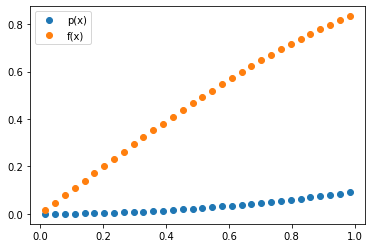

In [12]:
%matplotlib inline
plt.plot(X, p_X, 'o')
plt.plot(X, f_X, 'o')
plt.legend(['p(x)', 'f(x)'])

## 3. Loading Probability

The $\mathcal{P}$ is implemented by the function **load_p_gate** from the **dataloading_module**. The input should be a numpy array with the Probability distribution to load into the quantum state. The output of the function is a **qlm** *AbstractGate* customized for the input numpy array which load it into the quantum state. 


In [13]:
from dataloading_module import load_p_gate

In [14]:
p_gate = load_p_gate(p_X)

In [15]:
%qatdisplay p_gate --depth 1

We can use the *get_results* of **data_extracting** for executing the gate in a  circuit. This functions receives a quantum object, creates the asociated circuit and job. Finally execute the job and get results!!

In [16]:
from data_extracting import get_results

In [17]:
#We need to avoid last qbit
pdf, circuit, q_prog, job = get_results(p_gate, linalg_qpu=linalg_qpu, qubits=list(range(p_gate.arity)))

Submitted a new batch: Job6230


In [18]:
%qatdisplay circuit

In [19]:
circuit.statistics()

{'nbqbits': 6,
 'size': 1,
 'gates': {'custom gate': 0,
  'RY': 1,
  'X': 196,
  'C-X': 4,
  'C-RY': 30,
  'C-C-X': 8,
  'C-C-C-X': 16,
  'C-C-C-C-X': 32},
 'measurements': 0,
 'resets': 0,
 'logic': 0,
 'breaks': 0,
 'remaps': 0,
 'gate_size': 287}

In [20]:
pdf.head()

,Probability,States,Amplitude,Int,Int_lsb
0,0.000023,|00000>,None,0,0
1,0.000206,|00001>,None,1,16
2,0.000572,|00010>,None,2,8
3,0.001122,|00011>,None,3,24
4,0.001854,|00100>,None,4,4


In order to check if the operation was done properly we can compare the outpus probability of each state and the probabilities wanted to load:

In [21]:
np.isclose(pdf['Probability'], p_X).all()

True

## 3. Loading Integral of a function

The $\mathcal{F}$ is implemented by an Abstract qlm gate called **load_f_gate**. The input should be a numpy array with the function which integral want to be load into the quantum state. The output of the function is a **qlm** *AbstractGate* customized for the input numpy array which load the integral into the last qbit of the quantum state. 

The length of this array should be: $m=2^n$ where n is an integer. The created gate is a $n+1$ gate where the last qbit codifies the integral of the function.


In [48]:
from dataloading_module import load_f_gate

In [49]:
f_gate = load_f_gate(f_X)

In [50]:
%qatdisplay f_gate --depth 1

For using this gate first we need a equal superposition of states

In [51]:
q_rout = qlm.QRoutine()
q_bit = q_rout.new_wires(f_gate.arity)
#Loading an uniform distribution
for i in range(len(q_bit)-1):
    q_rout.apply(qlm.H, q_bit[i])
q_rout.apply(f_gate, q_bit)

In [52]:
%qatdisplay q_rout --depth 0

In [53]:
pdf, circuit, q_prog, job = get_results(q_rout, linalg_qpu=linalg_qpu, qubits=[f_gate.arity-1])

Submitted a new batch: Job6233


In [54]:
%qatdisplay circuit --depth 1

In [55]:
#Integral of f(x)
MeasurementIntegral = pdf['Probability'][1]*2**(n_qbits)

In [56]:
MeasurementIntegral

14.710924793974819

In [57]:
np.isclose(MeasurementIntegral, sum(f_X))

True

In [58]:
sum(f_X)

14.71092479397483

In [43]:
pdf

,Probability,States,Amplitude,Int,Int_lsb
0,0.330375,|0>,None,0,0
1,0.669625,|1>,None,1,1


## 4.Load Complete Data

If we have a variable $x$ that follows a probability distribution $p(x)$ we want to calculate the expectaction value of a function $f(x)$. So we want to compute:

$$E_{x\sim p}(f) = \int p(x)f(x)dx$$

Or in a discretized way:

$$E_{x\sim p}(f) = \sum_{x=0}^{2^n-1} p(x)f(x)dx$$

In order to do this first we need to load $p(x)$ and $f(x)$ in a quantum state:

$$|\Psi\rangle = \mathcal{F}(\mathcal{P} \otimes \mathbf{I})|0\rangle_{n}|0\rangle = \sum_{x=0}^{2^{n}-1}\sqrt{p(x)}|x\rangle_{n}\otimes (\sqrt{f(x)}|1\rangle +\sqrt{1-f(x)}|0\rangle)$$


In [31]:
from dataloading_module import load_pf

In [32]:
pf_gate = load_pf(p_gate, f_gate)

In [34]:
%qatdisplay pf_gate --depth 1

In [41]:
circuit.statistics()

{'nbqbits': 7,
 'size': 1,
 'gates': {'custom gate': 0,
  'RY': 1,
  'X': 516,
  'C-X': 4,
  'C-RY': 62,
  'C-C-X': 8,
  'C-C-C-X': 16,
  'C-C-C-C-X': 32,
  'C-C-C-C-C-X': 64},
 'measurements': 0,
 'resets': 0,
 'logic': 0,
 'breaks': 0,
 'remaps': 0,
 'gate_size': 703}

In [40]:
%qatdisplay circuit --depth 1

The $E_{x\sim p}(f)$ is codified in the last qbit!

In [35]:
pdf, circuit, q_prog, job = get_results(pf_gate, linalg_qpu=linalg_qpu, qubits=[pf_gate.arity-1])

Submitted a new batch: Job6232


In [37]:
#Integral of f(x)
MeasurementIntegral = pdf['Probability'][1]

In [36]:
pdf

,Probability,States,Amplitude,Int,Int_lsb
0,0.330375,|0>,None,0,0
1,0.669625,|1>,None,1,1


In [38]:
np.isclose(MeasurementIntegral, sum(p_X*f_X))

True